In [1]:
import os
import gym
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import math
import random
import matplotlib.pyplot as plt
import random



2022-03-18 14:45:42.914626: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-18 14:45:42.914645: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
#define the agent
class Agent: 
    def __init__(self, state_size, action_size):
        #parameters
        self.model_anatomy = [24, 24] 
        self.default_name = "DeepQNetwork"
        self.weight_backup_default = "cartpole_weight.h5"
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.learning_rate = 0.001
        self.gamma = 0.95
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.exploration_decay = 0.995
        self.sample_batch_size = 32
        #debug options
        self.model_summary = True
        
        self.model = self._build_model()
        
    def _build_model(self):
        #input layer
        inputs = keras.Input(shape=self.state_size)
        x = layers.Dense(self.model_anatomy[0])(inputs)
        #create hidden layers
        for num_neurons in self.model_anatomy[1:]:
            x = layers.Dense(num_neurons, activation="relu")(x)
        #output layer
        outputs = layers.Dense(self.action_size, activation = "linear")(x)
        
        #create model
        model = keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                     loss="mse")
        #model summary if enabled
        if self.model_summary: model.summary()
        return model
    
    def update_memory(self, step : tuple):
        #Format of step: [state(t), reward(t+1), action(t), state(t+1), done?]
        self.memory.append(step)
    
    def pick_action(self, state):
        
        if random.random() < self.exploration_rate:
            #return random move  
            return random.randrange(self.action_size)
        
        q_values = self.predict(state)
        
        #return action with the highest expected reward
        return np.argmax(q_values)
    
    def predict(self, state):
        return self.model.predict(state)
    
    def replay(self):
        if len(self.memory) < self.sample_batch_size:
            return
        
        #replay
        sample_batch = random.sample(self.memory, self.sample_batch_size)
        for state, action, reward, next_state, done in sample_batch:
            target = reward
            if not done:
              target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])      
            target_f = self.model.predict(state)
            target_f[0][action] = target
            
            #Training
            self.model.fit(state, target_f, epochs=1, verbose=0)
            
        #update exploration rate
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay
    
    def save_model(self):
        pass
    
    def load_model(self):
        pass

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 24)                120       
                                                                 
 dense_1 (Dense)             (None, 24)                600       
                                                                 
 dense_2 (Dense)             (None, 2)                 50        
                                                                 
Total params: 770
Trainable params: 770
Non-trainable params: 0
_________________________________________________________________
Episode:          0
Score:           25
__________


2022-03-18 14:45:45.194577: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-18 14:45:45.194599: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-18 14:45:45.194613: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (topas): /proc/driver/nvidia/version does not exist
2022-03-18 14:45:45.194790: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


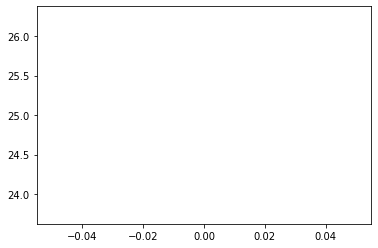

Episode:          1
Score:           16
__________
Episode:          2
Score:           34
__________
Episode:          3
Score:           29
__________
Episode:          4
Score:           23
__________
Episode:          5
Score:           41
__________
Episode:          6
Score:           20
__________
Episode:          7
Score:           33
__________
Episode:          8
Score:           29
__________
Episode:          9
Score:           32
__________
Episode:         10
Score:           34
__________
Episode:         11
Score:           18
__________
Episode:         12
Score:           35
__________
Episode:         13
Score:           20
__________
Episode:         14
Score:           18
__________
Episode:         15
Score:           11
__________
Episode:         16
Score:           36
__________
Episode:         17
Score:           67
__________
Episode:         18
Score:           17
__________
Episode:         19
Score:           18
__________
Episode:         20
Score:     

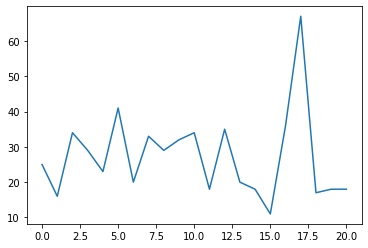

Episode:         21
Score:           30
__________
Episode:         22
Score:           49
__________
Episode:         23
Score:           18
__________
Episode:         24
Score:           15
__________
Episode:         25
Score:           19
__________
Episode:         26
Score:           13
__________
Episode:         27
Score:           16
__________
Episode:         28
Score:           22
__________
Episode:         29
Score:           14
__________
Episode:         30
Score:           17
__________
Episode:         31
Score:           11
__________
Episode:         32
Score:           17
__________
Episode:         33
Score:            9
__________
Episode:         34
Score:           11
__________


In [ ]:
class CartPole:
    def __init__(self):
        self.sample_batch_size = 32
        self.episodes          = 10000
        self.env               = gym.make('CartPole-v1')

        self.state_size        = self.env.observation_space.shape[0]
        self.action_size       = self.env.action_space.n
        self.agent             = Agent(self.state_size, self.action_size)

        self.history           = []
    def run(self):
        try:
            for index_episode in range(self.episodes):
                state = self.env.reset()
                state = np.reshape(state, [1, self.state_size])

                done = False
                index = 0
                while not done:
                    #self.env.render()

                    action = self.agent.pick_action(state)

                    next_state, reward, done, _ = self.env.step(action)
                    next_state = np.reshape(next_state, [1, self.state_size])
                    self.agent.update_memory((state, action, reward, next_state, done))
                    state = next_state
                    index += 1
                print(f"Episode: {index_episode:-10}")
                print(f"Score: {index:-12}")
                print("".join(["_" for i in range(10)]))
                self.history.append(index)
                self.agent.replay()
                
                if index_episode % 20 == 0:
                    plt.plot(self.history)
                    plt.show()
        finally:
            self.agent.save_model()

if __name__ == "__main__":
    cartpole = CartPole()
    cartpole.run()
